<a href="https://colab.research.google.com/github/Check-Your-Skin/checkyourskin-ml_model/blob/train-cnn-ham10000/Data%20Preparation/HAM10000_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import**

In [1]:
import os
import io
import shutil
import zipfile
import random

import pandas as pd
from glob import glob
from PIL import Image
from google.colab.patches import cv2_imshow
from concurrent.futures import ThreadPoolExecutor
import cv2

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization
from keras import metrics
from keras.metrics import Precision, Recall
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000/')

In [4]:
shutil.rmtree('/content/HAM10000/ham10000_images_part_1')
shutil.rmtree('/content/HAM10000/ham10000_images_part_2')

#Data Preparation

###Check Image Size

In [ ]:
width = 600
height = 450
wrong_size = 0
data = glob('/content/HAM10000/*')
for dir in data:
  if os.path.isdir(dir):
    images = glob(f'{dir}/*')
    for image in images:
      img = Image.open(image)
      w, h = img.size
      if (w != width or h != height):
        wrong_size =+ 1
        print(f'Path: {image}\nHeight: {h}\nWidth: {w}')
print(wrong_size)

0


###Resize Images





In [ ]:
def resize_image(image):
  img = Image.open(image)
  width, height = img.size
  global new_height
  global new_width
  new_height = 250
  new_width  = int(new_height * width / height)
  img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
  img_name = os.path.basename(image)
  img.save(resize_dest_dir + img_name)

In [ ]:
size = 128
resize_dest_dir = '/content/HAM10000/HAM10000_images/'
try:
  os.mkdir(resize_dest_dir)
except:
  pass
data = glob('/content/HAM10000/*')
for dir in data:
  if os.path.isdir(dir):
    images = glob(f'{dir}/*')
    with ThreadPoolExecutor() as executor:
      executor.map(resize_image, images)

In [5]:
resize_dest_dir = '/content/HAM10000/HAM10000_images/'
data = glob('/content/HAM10000/*')
try:
  os.mkdir(resize_dest_dir)
except:
  pass
for dir in data:
  if os.path.isdir(dir):
    images = glob(f'{dir}/*')
    for image in images:
      shutil.copy(image, resize_dest_dir)

In [6]:
print(len(glob('/content/HAM10000/HAM10000_images/*')))

10015


In [7]:
shutil.rmtree('/content/HAM10000/HAM10000_images_part_1')
shutil.rmtree('/content/HAM10000/HAM10000_images_part_2')

In [8]:
#Dictionary to match the Image_id with the Path of the Image
imgPath = {}
for x in glob(os.path.join('/content/HAM10000/HAM10000_images/*.jpg')):
    imgPath[os.path.splitext(os.path.basename(x))[0]] = x

In [9]:
#Add Resized Image data to DataFrame
file_path = '/content/HAM10000/HAM10000_metadata.csv'
df = pd.read_csv(file_path)


size = (128,128)
df['image'] = df['image_id'].map(imgPath.get).map(lambda x: np.asarray(Image.open(x).resize(size)))

In [10]:
#Adding numerical lable for one-hot encoding
numerical_label = LabelEncoder().fit(df['dx']).transform(df['dx'])
df['label'] = numerical_label

In [11]:
x = np.asarray(df['image'].to_list())
x = x / 255
y = df['label']
y = to_categorical(y, num_classes=7)
x_train, x_sum, y_train, y_sum = train_test_split(x, y, train_size=0.7, shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_sum, y_sum, test_size=0.5)

In [12]:
print('Train: ',len(x_train))
print('Test: ',len(x_test))
print('Validation: ',len(x_valid))

Train:  7010
Test:  1503
Validation:  1502


##Claculating Class Weights

In [21]:
Y_train = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(Y_train),y=Y_train)
class_weights = dict(zip(np.unique(Y_train),class_weights))
class_weights

{0: 4.510939510939511,
 1: 2.8130016051364364,
 2: 1.295509148031787,
 3: 13.00556586270872,
 4: 1.3039434523809523,
 5: 0.2127078528947688,
 6: 9.44743935309973}

#Build Model

In [40]:
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(input_shape=(128,128,3), filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Convolutional Block 2
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Convolutional Block 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation="relu"))
model.add(BatchNormalization())

model.add(Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)       

In [42]:
learning_rate = 0.0005

optimizer = Adam(learning_rate=learning_rate)

optimizer_name = 'Adam'

loss_name = 'categorical_crossentropy'

model.compile(optimizer=optimizer,
              loss=loss_name,
              metrics = ['accuracy'])

In [43]:
hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=8, class_weight=class_weights)

Epoch 1/30
877/877 [==============================] - 13s 10ms/step - loss: 2.0425 - accuracy: 0.2476 - val_loss: 1.5778 - val_accuracy: 0.3881
Epoch 2/30
877/877 [==============================] - 8s 9ms/step - loss: 1.8217 - accuracy: 0.2853 - val_loss: 1.6118 - val_accuracy: 0.2490
Epoch 3/30
877/877 [==============================] - 8s 9ms/step - loss: 1.7553 - accuracy: 0.3401 - val_loss: 1.6563 - val_accuracy: 0.3096
Epoch 4/30
877/877 [==============================] - 8s 9ms/step - loss: 1.7988 - accuracy: 0.3241 - val_loss: 1.8130 - val_accuracy: 0.2763
Epoch 5/30
877/877 [==============================] - 8s 9ms/step - loss: 1.7354 - accuracy: 0.3785 - val_loss: 1.4759 - val_accuracy: 0.4680
Epoch 6/30
877/877 [==============================] - 8s 9ms/step - loss: 1.7145 - accuracy: 0.3773 - val_loss: 1.3954 - val_accuracy: 0.4188
Epoch 7/30
877/877 [==============================] - 8s 9ms/step - loss: 1.6048 - accuracy: 0.3752 - val_loss: 1.5220 - val_accuracy: 0.4441
Epoc

#Evaluation

In [44]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Accuracy: ', test_accuracy)
print('Loss: ', test_loss)

47/47 [==============================] - 0s 7ms/step - loss: 0.9987 - accuracy: 0.6354
Accuracy:  0.635395884513855
Loss:  0.9986700415611267


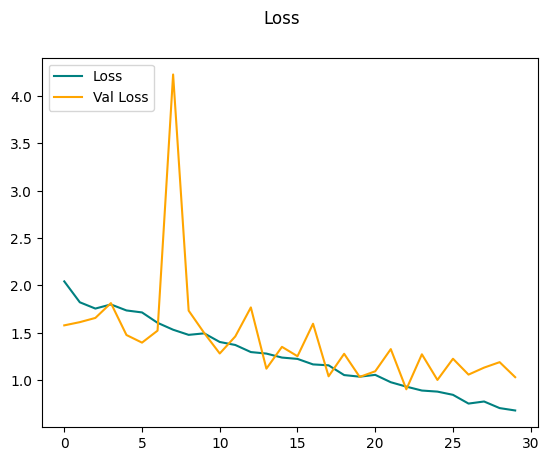

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Val Loss')
fig.suptitle('Loss')
plt.legend(loc='upper left')
plt.show()

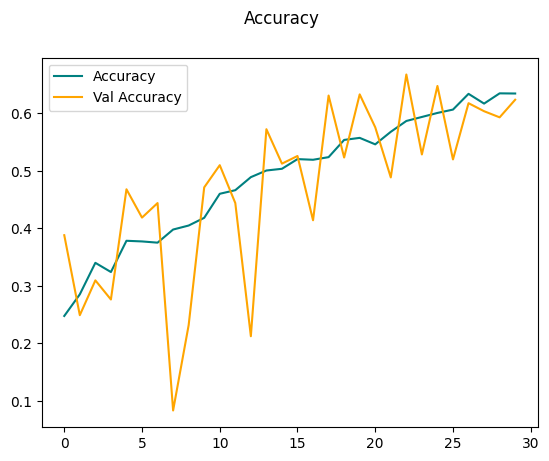

In [46]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Val Accuracy')
fig.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

47/47 [==============================] - 1s 5ms/step


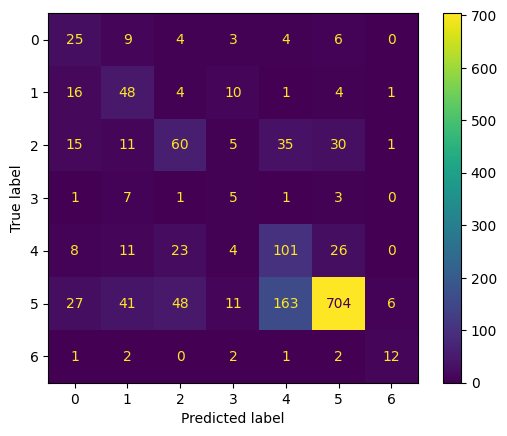

In [47]:
Y_pred = model.predict(x_test)
Y_pred = np.argmax(Y_pred,axis=1)
Y_test = np.argmax(y_test,axis=1)
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
plt.show()

In [48]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.27      0.49      0.35        51
           1       0.37      0.57      0.45        84
           2       0.43      0.38      0.40       157
           3       0.12      0.28      0.17        18
           4       0.33      0.58      0.42       173
           5       0.91      0.70      0.79      1000
           6       0.60      0.60      0.60        20

    accuracy                           0.64      1503
   macro avg       0.43      0.52      0.46      1503
weighted avg       0.73      0.64      0.67      1503



In [ ]:
unique, counts = np.unique(Y_train, return_counts=True)
label_count = dict(zip(unique, counts))
for i in range(7):
  print(i,'  ',label_count.get(i))

for i in range(7):
  print(i,'  ',label_count.get(i)*class_weights.get(i))

#Save / Load Model

In [ ]:
model.save('/content/drive/My Drive/ML-Models/')

In [8]:
model = load_model('/content/drive/My Drive/ML-Models/')